In [485]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import griddata
import h5py


def demread(file, lattar, lontar):
    datatemp = io.loadmat(file)
    demori = datatemp['DEM']
    demori[np.isnan(demori)] = 0
    info = datatemp['Info'][0][0]
    latori = np.arange(info['yll'] + info['Ysize'] * info['nrows'] - info['Ysize'] / 2, info['yll'], -info['Ysize'])
    lonori = np.arange(info['xll'] + info['Xsize'] / 2, info['xll'] + info['Xsize'] * info['ncols'], info['Xsize'])
    f = interp2d(lonori, latori, demori, kind='linear')
    demtar = f(lontar.flatten(), lattar.flatten())
    demtar = np.flipud(demtar)
    return demtar


def neargrid(rowtar, coltar, rowori, colori, hwsize):
    # inputs are 1D matrices
    # tar is target area
    # ori is original area
    # hwsize is half window size (e.g., 4 means the space window width/length is 2*4+1)
    # find a space window centering the target grid in the original area and calculate the weights
    nrows = len(rowtar)
    ncols = len(coltar)
    rowse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    colse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    weight = np.nan * np.zeros([nrows, ncols, (hwsize * 2 + 1) ** 2])  # from left to right/from top to bottom weight

    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        rowse[rr, :, 0] = rowloc - hwsize
        rowse[rr, :, 1] = rowloc + hwsize

    for cc in range(ncols):
        colloc = np.argmin(np.abs(colori - coltar[cc]))
        colse[:, cc, 0] = colloc - hwsize
        colse[:, cc, 1] = colloc + hwsize

    rowse[rowse < 0] = 0
    rowse[rowse > nrows] = nrows
    colse[colse < 0] = 0
    colse[colse > ncols] = nrows

    maxdist = (hwsize + 0.5) * np.sqrt(2) + 0.5
    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        for cc in range(ncols):
            colloc = np.argmin(np.abs(colori - coltar[cc]))

            rowse_rc = rowse[rr, cc, :]
            colse_rc = colse[rr, cc, :]
            flag = 0
            for i in range(rowse_rc[0], rowse_rc[1] + 1):
                for j in range(colse_rc[0], colse_rc[1] + 1):
                    dist = ((rowloc - i) ** 2 + (colloc - j) ** 2) ** 0.5
                    weight[rr, cc, flag] = au.distanceweight(dist, maxdist, 3)
                    flag = flag + 1

            weight[rr, cc, :] = weight[rr, cc, :] / np.nansum(weight[rr, cc, :])

    return rowse, colse, weight


def readownscale(dataori, latori, lonori, demori, lattar, lontar, demtar, rowse, colse, weight, mask):
    nrows = len(lattar)
    ncols = len(lontar)
    ntimes = np.shape(dataori)[2]
    lonori, latori = np.meshgrid(lonori, latori)
    datatar = np.nan * np.zeros([nrows, ncols, ntimes])

    for rr in range(nrows):
        for cc in range(ncols):
            if mask[rr, cc] == 1:
                rloc = rowse[rr, cc, :]
                cloc = colse[rr, cc, :]
                latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                nnum = np.size(latnear)
                latnear = np.reshape(latnear, nnum)
                lonnear = np.reshape(lonnear, nnum)
                demnear = np.reshape(demnear, nnum)
                weightnear = np.zeros([nnum, nnum])
                for i in range(nnum):
                    weightnear[i, i] = weight[rr, cc, i]

                nearinfo = np.zeros([nnum, 4])
                nearinfo[:, 0] = 1
                nearinfo[:, 1] = latnear
                nearinfo[:, 2] = lonnear
                nearinfo[:, 3] = demnear

                tarinfo = np.zeros(4)
                tarinfo[0] = 1
                tarinfo[1] = lattar[rr]
                tarinfo[2] = lontar[cc]
                tarinfo[3] = demtar[rr, cc]

                tx_red = np.transpose(nearinfo)
                twx_red = np.matmul(tx_red, weightnear)

                for tt in range(3):
                    datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
                    datanear = np.reshape(datanear, nnum)

                    # upper and lower boundary for the downscaled data
                    # this is a conservative limitation
                    lowbound = np.min(datanear)
                    upbound = np.max(datanear)

                    b = reg.least_squares(nearinfo, datanear, twx_red)
                    datatemp = np.dot(tarinfo, b)
                    if np.all(b == 0) or datatemp > upbound or datatemp < lowbound:
                        # use nearest neighbor interpolation
                        weightnear = weight[rr, cc, 0:nnum]
                        mloc = np.argmax(weightnear)
                        datatar[rr, cc, tt] = datanear[mloc]
                    else:
                        datatar[rr, cc, tt] = datatemp
    return datatar


def readownscale_tostn(dataori, latori, lonori, demori, lattar, lontar, demtar, rowse, colse, weight, stn_row, stn_col,
                       data0):
    nstn = len(stn_row)
    ntimes = np.shape(dataori)[2]
    lonori, latori = np.meshgrid(lonori, latori)
    datatar = np.nan * np.zeros([nstn, ntimes])

    for gg in range(nstn):
        if np.mod(gg, 5000) == 0:
            print('station', gg, nstn)

        if np.isnan(data0[gg]):
            continue  # station does not have observations, thus does not need downscaling

        rr = stn_row[gg]
        cc = stn_col[gg]
        rloc = rowse[rr, cc, :]
        cloc = colse[rr, cc, :]
        latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
        lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
        demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
        nnum = np.size(latnear)
        latnear = np.reshape(latnear, nnum)
        lonnear = np.reshape(lonnear, nnum)
        demnear = np.reshape(demnear, nnum)
        weightnear = np.zeros([nnum, nnum])
        for i in range(nnum):
            weightnear[i, i] = weight[rr, cc, i]

        nearinfo = np.zeros([nnum, 4])
        nearinfo[:, 0] = 1
        nearinfo[:, 1] = latnear
        nearinfo[:, 2] = lonnear
        nearinfo[:, 3] = demnear

        tarinfo = np.zeros(4)
        tarinfo[0] = 1
        tarinfo[1] = lattar[rr]
        tarinfo[2] = lontar[cc]
        tarinfo[3] = demtar[rr, cc]

        tx_red = np.transpose(nearinfo)
        twx_red = np.matmul(tx_red, weightnear)

        for tt in range(ntimes):
            datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
            datanear = np.reshape(datanear, nnum)

            # upper and lower boundary for the downscaled data
            # this is a conservative limitation
            lowbound = np.min(datanear)
            upbound = np.max(datanear)

            b = reg.least_squares(nearinfo, datanear, twx_red)
            datatemp = np.dot(tarinfo, b)
            if np.all(b == 0) or datatemp > upbound or datatemp < lowbound:
                # use nearest neighbor interpolation
                weightnear = weight[rr, cc, 0:nnum]
                mloc = np.argmax(weightnear)
                datatar[gg, tt] = datanear[mloc]
            else:
                datatar[gg, tt] = datatemp
    return datatar


def readstndata(inpath, stnID, ndays):
    nstn = len(stnID)
    prcp_stn = np.nan * np.zeros([nstn, ndays])
    tmin_stn = np.nan * np.zeros([nstn, ndays])
    tmax_stn = np.nan * np.zeros([nstn, ndays])

    for i in range(nstn):
        if np.mod(i, 1000) == 0:
            print('station', i, nstn)
        file = inpath + '/' + stnID[i] + '.nc'
        fid = nc.Dataset(file)
        varlist = fid.variables.keys()
        if 'prcp' in varlist:
            prcp_stn[i, :] = fid['prcp'][:].data
        if 'tmin' in varlist:
            tmin_stn[i, :] = fid['tmin'][:].data
        if 'tmax' in varlist:
            tmax_stn[i, :] = fid['tmax'][:].data
        fid.close()

    tmean_stn = (tmin_stn + tmax_stn) / 2
    trange_stn = np.abs(tmax_stn - tmin_stn)

    return prcp_stn, tmean_stn, trange_stn


########################################################################################################################
# time periods: inside or outside
# outside
# a = int(sys.argv[1])
# b = int(sys.argv[2])
# year = [a, b]
# inside
year = [1980,1980]
print('start/end year', year)
########################################################################################################################

# basic information: be set before running
# mac
filedem = './DEM/NA_DEM_010deg_trim.mat'
# plato
# filedem = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
vars = ['prcp', 'tmin', 'tmax']
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
hwsize = 2  # use (2*2+1)**2 grids to perform regression

# station information
# mac
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stnpath = '/Users/localuser/GMET/StnInput_daily'
gmet_stndatafile = '/Users/localuser/GMET/pyGMET_NA/stndata_whole.npz' # to be saved. only process when absent
# plato
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stnpath = '/home/gut428/GMET/StnInput_daily'
# gmet_stndatafile = '/home/gut428/stndata_whole.npz'  # to be saved. only process when absent

# reanalysis path: ERA-5
# mac
filedem_era = './DEM/MERRA2_DEM2.mat'
inpath = '/Users/localuser/Research/Test'
outpath = '/Users/localuser/Research'
# plato
# filedem_era = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/MERRA2_DEM2.mat'
# inpath = '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_raw'  # downscale to 0.1 degree
# outpath = '/home/gut428/MERRA2_day_ds'
# file_readownstn = outpath + '/MERRA2_downto_stn.npz'  # downscale to station points (1979-2018)
filenear = outpath + '/weight_dem_merra.npz'

########################################################################################################################

# read some basic infomation
datatemp = io.loadmat(filedem)
demtar = datatemp['DEM']  # this is consistent with lontar lattar
mask = demtar.copy()
mask[~np.isnan(mask)] = 1

stn_ID = np.genfromtxt(gmet_stnfile, dtype='str', skip_header=1, comments='#', delimiter=',', usecols=(0), unpack=False)
stn_lle = np.loadtxt(gmet_stnfile, dtype=float, skiprows=1, comments='#', delimiter=',', usecols=(1, 2, 3),
                     unpack=False)
stn_row = ((85 - stn_lle[:, 0]) / 0.1).astype(int)
stn_col = ((stn_lle[:, 1] + 180) / 0.1).astype(int)
nstn = len(stn_ID)
ndays = 14610  # days from 1979 to 2018

# read all station data and save to facilitate analysis in the future
if not os.path.isfile(gmet_stndatafile):
    prcp_stn, tmean_stn, trange_stn = readstndata(gmet_stnpath, stn_ID, ndays)
    prcp_stn = np.float32(prcp_stn)
    tmean_stn = np.float32(tmean_stn)
    trange_stn = np.float32(trange_stn)
    np.savez_compressed(gmet_stndatafile, prcp_stn=prcp_stn, tmean_stn=tmean_stn, trange_stn=trange_stn,
                        stn_ID=stn_ID, stn_lle=stn_lle, stn_row=stn_row, stn_col=stn_col)

########################################################################################################################

# downscale reanalysis to 0.1 degree
for y in range(year[0], year[1] + 1):
    for v in range(1,2):
        print('year--var:', y, vars[v])
        infile = inpath + '/MERRA2_' + vars[v] + '_' + str(y) + '.mat'
        outfile_grid = outpath + '/MERRA2_' + vars[v] + '_' + str(y) + '.npz'
        if os.path.isfile(outfile_grid):
            continue

        # load original daily reanalysis data
        datatemp = {}
        f = h5py.File(infile, 'r')
        for k, v in f.items():
            datatemp[k] = np.array(v)
        latori = datatemp['latitude'][0]
        lonori = datatemp['longitude'][0]
        dataori = datatemp['data']
        dataori = np.transpose(dataori, [2, 1, 0])
        del datatemp
        f.close()

        # read location information
        if not os.path.isfile(filenear):
            rowse, colse, weight = neargrid(lattar, lontar, latori, lonori, hwsize)
            # extract ori dem
            demori = demread(filedem_era, latori, lonori)
            io.savemat(filenear, {'rowse': rowse, 'colse': colse, 'weight': weight, 'demori': demori})
        else:
            datatemp = io.loadmat(filenear)
            rowse = datatemp['rowse']
            colse = datatemp['colse']
            weight = datatemp['weight']
            demori = datatemp['demori']
            del datatemp

        # downscale the reanalysis to 0.1 degree
        datatar = readownscale(dataori, latori, lonori, demori, lattar, lontar, demtar, rowse, colse, weight, mask)
        datatar = np.float32(datatar)

start/end year [1980, 1980]
year--var: 1980 tmin


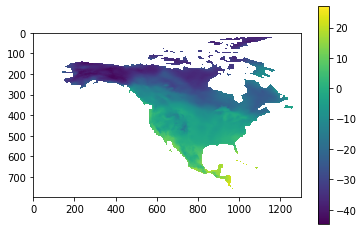

In [489]:
plt.imshow(datatar[:,:,0])
plt.colorbar()

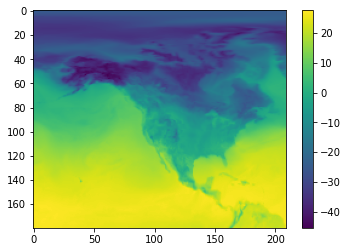

In [488]:
plt.imshow(dataori[:,:,0])
plt.colorbar()

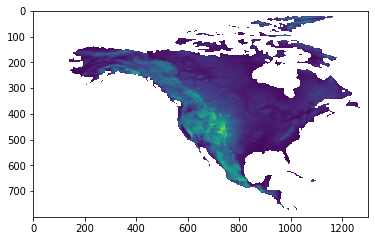

In [480]:
plt.imshow(demtar)

In [481]:
demtar[337,8]

229.18980407714844

In [449]:
demori = demread(filedem_era, latori, lonori)
print(np.shape(demori))

(361, 576)


In [446]:
        if not os.path.isfile(filenear):
            rowse, colse, weight = neargrid(lattar, lontar, latori, lonori, hwsize)
            # extract ori dem
            demori = demread(filedem_era, latori, lonori)
            io.savemat(filenear, {'rowse': rowse, 'colse': colse, 'weight': weight, 'demori': demori})
        else:
            datatemp = io.loadmat(filenear)
            rowse = datatemp['rowse']
            colse = datatemp['colse']
            weight = datatemp['weight']
            demori = datatemp['demori']
            del datatemp

In [10]:
import numpy as np
from matplotlib import pyplot as plt
file='/Users/localuser/Downloads/JRA55_tmin_1979.npz'
d=np.load(file)
d=d['data']

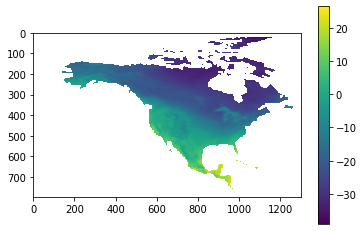

In [13]:
plt.imshow(d[:,:,10])
plt.colorbar()

In [15]:
np.isnan(1) | np.isnan(2)

False